## Load data

In [1]:
import time
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import reduce
from tqdm import tqdm  

# Configure seaborn aesthetics
sns.set(style="whitegrid")

In [2]:
# Path to your large text file
path = '/kaggle/input/large-txt/large-txt.txt'

# Load the data
print("Loading data...")
with open(path, 'r', encoding='latin') as f:
    lines = f.readlines()
print(f"Total lines loaded: {len(lines)}")

Loading data...
Total lines loaded: 2225370


## Single-Processor Word Count

In [7]:
def word_count_single_processor(data_lines):
    """
    Compte les occurrences des mots en utilisant un seul processeur sans utiliser de bibliothèques externes.
    Mesure et retourne le temps écoulé.
    """
    start_time = time.time()
    word_counts = {}

    for line in data_lines:
        words = line.split() 
        for word in words:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

    end_time = time.time()
    elapsed_time = end_time - start_time
    return word_counts, elapsed_time


In [8]:
print("\nRunning Single-Processor Word Count...")
single_counts, single_time = word_count_single_processor(lines)
print(f"Single-Processor Time Taken: {single_time:.4f} seconds")
print(f"Number of unique words (single-processor): {len(single_counts)}")



Running Single-Processor Word Count...
Single-Processor Time Taken: 10.0582 seconds
Number of unique words (single-processor): 615470


## Multi-Processor (MapReduce) Word Count

In [11]:
def split_into_chunks(data_lines, num_chunks):
    """
    Splits the list of lines into num_chunks chunks.
    Returns a list of chunk strings.
    """
    chunk_size = len(data_lines) // num_chunks
    chunks = []
    start = 0
    for i in range(num_chunks):
        if i == num_chunks - 1:
            chunk_lines = data_lines[start:]
        else:
            chunk_lines = data_lines[start : start + chunk_size]
        start += chunk_size
        chunks.append(" ".join(chunk_lines))
    return chunks

def map_function(text_chunk):
    """Fonction de map : retourne un dictionnaire des fréquences de mots pour le morceau de texte."""
    word_freq = {}
    for word in text_chunk.split():
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
    return word_freq

def reduce_function(counter_a, counter_b):
    """Reduce function: merges two word count dictionaries by summing counts."""
    for word, count in counter_b.items():
        if word in counter_a:
            counter_a[word] += count
        else:
            counter_a[word] = count
    return counter_a

def word_count_multiprocess(data_lines, processes=2):
    """
    Counts word occurrences using multiple processors.
    Measures and returns the time taken for each stage and the final counts.
    """
    timings = {}
    t_start_total = time.time()
    
    # Chunking
    t_start_chunk = time.time()
    chunks = split_into_chunks(data_lines, num_chunks=processes)
    t_end_chunk = time.time()
    timings['time_chunk'] = t_end_chunk - t_start_chunk
    
    # Mapping
    t_start_map = time.time()
    with multiprocessing.Pool(processes=processes) as pool:
        partial_counters = pool.map(map_function, chunks)
    t_end_map = time.time()
    timings['time_map'] = t_end_map - t_start_map
    
    # Reducing
    t_start_reduce = time.time()
    final_counts = reduce(reduce_function, partial_counters)
    t_end_reduce = time.time()
    timings['time_reduce'] = t_end_reduce - t_start_reduce
    
    t_end_total = time.time()
    timings['time_total'] = t_end_total - t_start_total
    
    return final_counts, timings


In [12]:
# Define processor configurations and number of runs
process_list = [2, 3, 4]
N_RUNS = 5

all_results = []

print("\nRunning Multi-Processor Experiments...")
for procs in process_list:
    print(f"\nNumber of Processes: {procs}")
    for run in tqdm(range(1, N_RUNS + 1), desc=f"Runs for {procs} processes"):
        counts, timings = word_count_multiprocess(lines, processes=procs)
        result = {'processes': procs,
                  'run': run,
                  'time_chunk': timings['time_chunk'],
                  'time_map': timings['time_map'],
                  'time_reduce': timings['time_reduce'],
                  'time_total': timings['time_total']}
        all_results.append(result)



Running Multi-Processor Experiments...

Number of Processes: 2


Runs for 2 processes: 100%|██████████| 5/5 [00:51<00:00, 10.34s/it]



Number of Processes: 3


Runs for 3 processes: 100%|██████████| 5/5 [00:47<00:00,  9.43s/it]



Number of Processes: 4


Runs for 4 processes: 100%|██████████| 5/5 [00:44<00:00,  8.98s/it]


## Collecting Single-Processor Metrics

In [13]:
SINGLE_N_RUNS = 5

print("\nRunning Single-Processor Experiments...")
single_results = []
for run in tqdm(range(1, SINGLE_N_RUNS + 1), desc="Single-Processor Runs"):
    _, single_time = word_count_single_processor(lines)
    result = {'processes': 1,
              'run': run,
              'time_chunk': None,  # Not applicable
              'time_map': None,    # Not applicable
              'time_reduce': None, # Not applicable
              'time_total': single_time}
    single_results.append(result)

all_results.extend(single_results)


Running Single-Processor Experiments...


Single-Processor Runs: 100%|██████████| 5/5 [00:51<00:00, 10.39s/it]


## Visualization of Results

In [14]:
# Convert all results to a pandas DataFrame
df_results = pd.DataFrame(all_results)
df_results.head(10)


,processes,run,time_chunk,time_map,time_reduce,time_total
0,2,1,0.455033,8.918890,0.188863,9.562804
1,2,2,0.449063,9.561818,0.194895,10.205798
2,2,3,0.460661,10.224002,0.213978,10.898665
3,2,4,0.481191,9.677080,0.202411,10.360703
4,2,5,0.461546,9.529784,0.207032,10.198382
5,3,1,0.451393,8.449681,0.347816,9.248907
6,3,2,0.464209,8.449800,0.353128,9.267155
7,3,3,0.483849,8.571523,0.348714,9.404112
8,3,4,0.491456,8.635455,0.343321,9.470255
9,3,5,0.453978,8.375245,0.384716,9.213958


In [15]:
# Statistical Summary
print("\nStatistical Summary (seconds):")
df_results.groupby('processes').agg(['mean', 'std'])



Statistical Summary (seconds):


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


run           time_chunk            time_map           time_reduce  \
          mean       std       mean       std      mean       std        mean   
processes                                                                       
1          3.0  1.581139        NaN       NaN       NaN       NaN         NaN   
2          3.0  1.581139   0.461499  0.012093  9.582315  0.464773    0.201436   
3          3.0  1.581139   0.468977  0.017912  8.496341  0.104896    0.355539   
4          3.0  1.581139   0.462281  0.003378  7.954261  0.256003    0.446722   

                    time_total            
                std       mean       std  
processes                                 
1               NaN  10.373679  0.159218  
2          0.009879  10.245270  0.476908  
3          0.016678   9.320877  0.110385  
4          0.010144   8.863281  0.261535

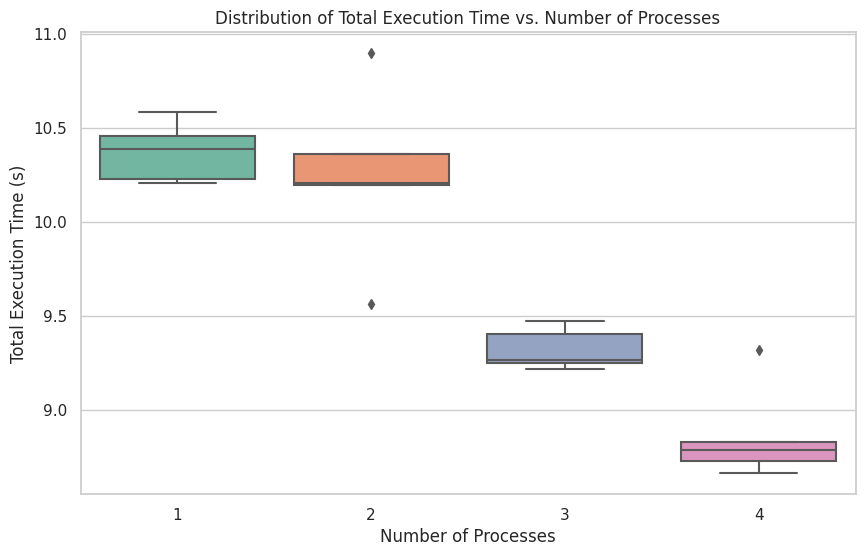

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='processes', y='time_total', data=df_results, palette="Set2")
plt.title("Distribution of Total Execution Time vs. Number of Processes")
plt.xlabel("Number of Processes")
plt.ylabel("Total Execution Time (s)")
plt.show()


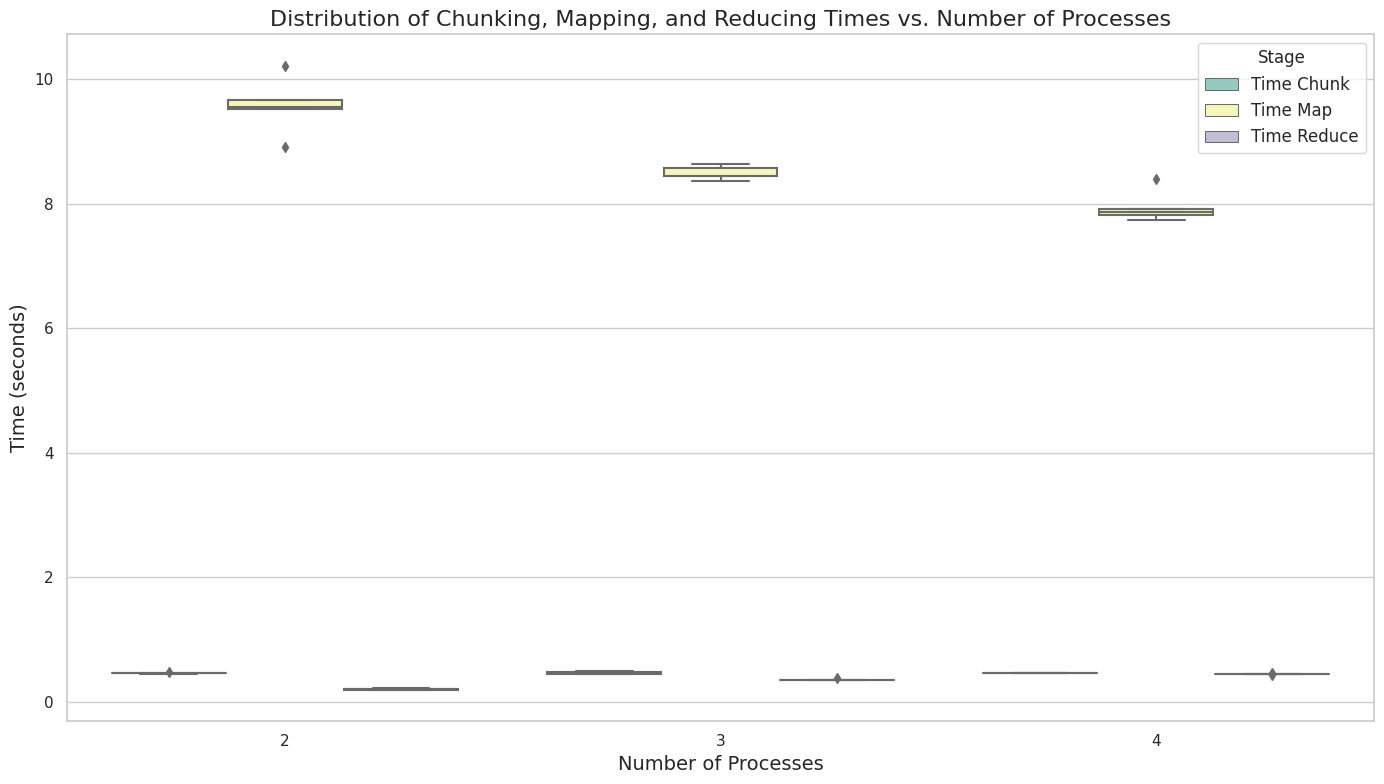

In [17]:
df_multi = df_results[df_results['processes'].isin([2, 3, 4])]

df_melted = df_multi.melt(
    id_vars=['processes', 'run'],
    value_vars=['time_chunk', 'time_map', 'time_reduce'],
    var_name='stage',
    value_name='time'
)

df_melted['stage'] = df_melted['stage'].str.replace('_', ' ').str.title()

plt.figure(figsize=(14, 8))
sns.boxplot(
    x='processes',
    y='time',
    hue='stage',
    data=df_melted,
    palette="Set3"
)
plt.title("Distribution of Chunking, Mapping, and Reducing Times vs. Number of Processes", fontsize=16)
plt.xlabel("Number of Processes", fontsize=14)
plt.ylabel("Time (seconds)", fontsize=14)
plt.legend(title="Stage", fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()
